In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import models
from torchvision.ops import nms, RoIPool

In [2]:
from src import display
from src import data_transformer as dt
from src.evaluation import PredBoundingBox, MAP # jaccard
from src.augmentations import RandomHorizontalFlip, RandomContrast
from src.faster_rcnn_utils import generator_anchors, loc2bbox, bbox2loc, random_choice, normal_init

In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
def intersect(box_a: torch.Tensor, box_b: torch.Tensor) -> float:
    # Coverting (cx, cy, w, h) to (x1, y1, x2, y2) since its easier to extract min/max coordinates
    #temp_box_a, temp_box_b = center_2_hw(box_a), center_2_hw(box_b)
    temp_box_a = box_a
    temp_box_b = box_b

    max_xy = torch.min(temp_box_a[:, None, 2:], temp_box_b[None, :, 2:])
    min_xy = torch.max(temp_box_a[:, None, :2], temp_box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def box_area(box: torch.Tensor) -> float:
    return (box[:, 2] - box[:, 0]) * (box[:, 3] - box[:, 1])


def jaccard(box_a: torch.Tensor, box_b: torch.Tensor) -> float:
    intersection = intersect(box_a, box_b)
    union = box_area(box_a).unsqueeze(1) + box_area(box_b).unsqueeze(0) - intersection
    return intersection / union

In [5]:
IMG_PATH = "./data/VOCdevkit/VOC2012/JPEGImages/"
train_json_path = "./data/VOCdevkit/VOC2012/cocoformatJson/voc_2012_train.json"
val_json_path = "./data/VOCdevkit/VOC2012/cocoformatJson/voc_2012_val.json"

In [6]:
target_size = 224
num_classes = 20

seed = 42
device = "cuda"

In [7]:
data_list = []
id_cat, temp_list = dt.load_pascal(train_json_path)
data_list += temp_list
_, temp_list = dt.load_pascal(val_json_path)
data_list += temp_list

random.seed(seed)
random.shuffle(data_list)

In [8]:
data_list = dt.rescale_bounding_boxes(data_list, target_size)
data_list = dt.convert_to_center(data_list)

In [9]:
example = data_list[0]
example

ImageEntry(filename='2009_004619.jpg', width=500, height=333, classnames=['train', 'person', 'person'], class_id=[18, 14, 14], bounding_boxes=[[112.0, 92.5, 224, 185], [80.0, 158.0, 26, 120], [167.0, 83.5, 26, 81]])

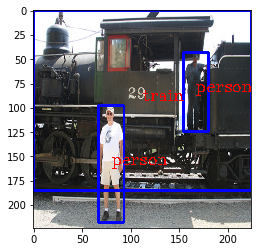

In [10]:
img_str = IMG_PATH + example.filename
img = display.read_img(img_str, target_size)

img = display.draw_boxes(img, example.bounding_boxes)
img = display.draw_text(img, example.classnames, example.bounding_boxes)
plt.imshow(img)
plt.show()

In [11]:
def center_to_minmax(bbox):
    xmin = bbox[:, 0] - 0.5 * bbox[:, 2]
    xmax = bbox[:, 0] + 0.5 * bbox[:, 2]

    ymin = bbox[:, 1] - 0.5 * bbox[:, 3]
    ymax = bbox[:, 1] + 0.5 * bbox[:, 3]
    return torch.stack([xmin, ymin, xmax, ymax], dim=1)


class PascalData(Dataset):
    def __init__(self, data_list_, target_size_=target_size, path_=IMG_PATH, p=0.5, train_mode=False):
        self.target_size = target_size_
        self.path = path_
        self.data_list = data_list_
        self.p = p

        self.mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
        self.std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

        self.train_mode = train_mode
        self.flip = RandomHorizontalFlip(p)
        self.contrast = RandomContrast(p)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]

        img_str = self.path + item.filename
        img = display.read_img(img_str, self.target_size)
        img = img / 255.0

        gt = np.vstack(item.bounding_boxes)

        #if self.train_mode:
        #    img = self.contrast(img)
        #    img, gt = self.flip(img, gt)

        img = img.transpose((2, 0, 1))
        img = (img - self.mean) / self.std
        img = torch.from_numpy(img).float()

        gt = torch.from_numpy(gt).float()
        gt = center_to_minmax(gt)        
        c = torch.from_numpy(np.array(item.class_id))

        return (img, gt, c)

def collate_fn(batch):
    """
    Writing custom collector function since the Dataset class returns both tensors and lists.
    """

    x = [b[0] for b in batch]
    x = torch.stack(x, dim=0)
    gt = [b[1] for b in batch]
    c = [b[2] for b in batch]
    return (x, gt, c)

In [12]:
batch_size = 128
train_size = 0.9

split_idx = int(train_size * len(data_list))

train_dataset = PascalData(data_list[0:split_idx], train_mode=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)

val_dataset = PascalData(data_list[split_idx:])
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [13]:
class ProposalLayer(nn.Module):
    def __init__(self, img_size, nms_thresh=0.7, n_train_pre_nms=2000, n_train_post_nms=1000,
                 n_test_pre_nms=600, n_test_post_nms=300, min_size=16):

        super().__init__()
        self.img_size = img_size
        self.nms_threshold = nms_thresh
        self.n_train_pre_nms = n_train_pre_nms
        self.n_train_post_nms = n_train_post_nms
        self.n_test_pre_nms = n_test_pre_nms
        self.n_test_post_nms = n_test_post_nms
        self.min_size = min_size

    def forward(self, locs, scores, anchors):
        if self.training:
            n_pre_nms = self.n_train_pre_nms
            n_post_nms = self.n_train_post_nms
        else:
            n_pre_nms = self.n_test_pre_nms
            n_post_nms = self.n_test_post_nms

        roi = loc2bbox(anchors, locs)
        roi = torch.clamp(roi, 0, self.img_size)

        # Remove predicted boxes with either height or width < threshold.
        widths = roi[:, 2] - roi[:, 0]
        heights = roi[:, 3] - roi[:, 1]
        keep = torch.where((heights >= self.min_size) & (widths >= self.min_size))[0]

        roi = roi[keep, :]
        scores = scores[keep]

        # Sort all (proposal, score) pairs by score from highest to lowest and the the n_pre_nms highest.        
        indicies = torch.argsort(scores, descending=True)        
        indicies = indicies[:n_pre_nms]
        roi = roi[indicies, :]
        scores = scores[indicies]

        keep = nms(roi, scores, self.nms_threshold)
        keep = keep[:n_post_nms]
        roi = roi[keep]

        return roi

In [14]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, img_size, in_channels=256, mid_channels=256, ratios=[0.7, 1, 1.3],
                 anchor_scales=[4, 8, 16], sub_sample=16):
        super().__init__()

        # Note: all images in the forward pass need to be of shape 3 x img_size x img_size
        self.img_size = img_size
        self.anchors = generator_anchors(img_size, sub_sample, anchor_scales=anchor_scales, ratios=ratios)
        self.num_base_anchors = len(ratios) * len(anchor_scales)

        self.proposal_layer = ProposalLayer(img_size)

        self.conv = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1)
        self.score = nn.Conv2d(mid_channels, 2 * self.num_base_anchors, kernel_size=1, stride=1, padding=0)
        self.loc = nn.Conv2d(mid_channels, 4 * self.num_base_anchors, kernel_size=1, stride=1, padding=0)

        normal_init(self.conv, 0.0, 0.01)
        normal_init(self.score, 0.0, 0.01)
        normal_init(self.loc, 0.0, 0.01)

    def forward(self, x):        
        n, _, height, width = x.shape        
        h = F.relu(self.conv(x))

        rpn_locs = self.loc(h)
        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)

        rpn_scores = self.score(h)
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous()

        rpn_softmax_scores = F.softmax(rpn_scores.view(n, height, width, self.num_base_anchors, 2), dim=4)

        rpn_fg_scores = rpn_softmax_scores[:, :, :, :, 1].contiguous()
        rpn_fg_scores = rpn_fg_scores.view(n, -1)
        rpn_scores = rpn_scores.view(n, -1, 2)

        rois = []
        roi_indices = []
        for i in range(n):
            roi = self.proposal_layer(rpn_locs[i], rpn_fg_scores[i], self.anchors)
            batch_index = i * torch.ones((len(roi),)).int()
            rois.append(roi)
            roi_indices.append(batch_index)

        rois = torch.cat(rois, dim=0).to(device)
        roi_indices = torch.cat(roi_indices, dim=0).to(device)
        return rpn_locs, rpn_scores, rois, roi_indices, self.anchors

In [15]:
class RoIHead(nn.Module):
    def __init__(self, num_classes, output_size, num_hidden=256, in_channels=256, sub_sample=16):
        super().__init__()

        self.linear = nn.Linear(output_size * output_size * in_channels, num_hidden)
        self.cls_loc = nn.Linear(num_hidden, 4 * num_classes)
        self.score = nn.Linear(num_hidden, num_classes)
        self.roi_pool = RoIPool(output_size, spatial_scale=1/sub_sample)

        normal_init(self.cls_loc, 0, 0.001)
        normal_init(self.score, 0, 0.01)

    def forward(self, x, rois, roi_indices):
        indicies_and_rois = torch.cat([
            roi_indices.float().unsqueeze(-1),
            rois
        ], dim=1)

        pool_vals = self.roi_pool(x, indicies_and_rois)
        pool_vals = pool_vals.view(pool_vals.size(0), -1)

        h = F.relu(self.linear(pool_vals))
        roi_cls_locs = self.cls_loc(h)
        roi_scores = self.score(h)
        return roi_cls_locs, roi_scores

In [16]:
class FasterRCNN(nn.Module):
    def __init__(self, img_size, num_classes, output_size=7):
        super().__init__()
        
        self.img_size = img_size
        self.num_classes = num_classes
        pretrained_model = list(models.resnet34(pretrained='imagenet').children())[:-3]
        self.backbone = nn.Sequential(*pretrained_model)
        self.region_proposal_network = RegionProposalNetwork(img_size, sub_sample=16)
        self.roi_head = RoIHead(num_classes, output_size)
        
    def change_freezing(self, mode=False):
        for param in self.backbone.parameters():
            param.requires_grad = mode

    def train(self, mode=True):
        super().train(mode)

        # Avoid updating BN stats
        for m in self.backbone.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    def forward_rpn(self, x):
        feature_map = self.backbone(x)
        rpn_locs, rpn_scores, rois, roi_indices, _ = self.region_proposal_network(feature_map)
        return rpn_locs, rpn_scores, rois, roi_indices, feature_map

    def forward_roi(self, x, rois, roi_indices):
        roi_cls_locs, roi_scores = self.roi_head(x, rois, roi_indices)
        return roi_cls_locs, roi_scores
    
    def predict(self, x):
        # Forward for inference
        # Currently only support batch_size=1
        assert len(x.shape) == 4 and x.shape[0] == 1

        rpn_locs, rpn_scores, rois, roi_indices, feature_map = self.forward_rpn(x)
        roi_cls_locs, roi_scores = self.forward_roi(feature_map, rois, roi_indices)

        roi_cls_locs = roi_cls_locs.view(-1, self.num_classes, 4)
        rois = rois.view(-1, 1, 4).expand_as(roi_cls_locs)

        cls_boxes = loc2bbox(rois.reshape(-1, 4), roi_cls_locs.reshape(-1, 4))
        cls_boxes = cls_boxes.view(-1, self.num_classes * 4)
        cls_boxes[:, 0::2] = torch.clamp(cls_boxes[:, 0::2], min=0, max=self.img_size)
        cls_boxes[:, 1::2] = torch.clamp(cls_boxes[:, 1::2], min=0, max=self.img_size)

        cls_boxes =  cls_boxes.view(-1,  self.num_classes, 4)        
        roi_scores = F.softmax(roi_scores, dim=1)

        return roi_scores, cls_boxes

In [17]:
def sample_labels(labels, n_sample=256, pos_ratio=0.5):
    n_pos = pos_ratio * n_sample

    pos_index = torch.where(labels == 1)[0]
    if len(pos_index) > n_pos:
        disable_index = random_choice(pos_index, size=int(len(pos_index) - n_pos))
        labels[disable_index] = -1

    n_neg = n_sample - torch.sum(labels == 1)
    neg_index = torch.where(labels == 0)[0]
    if len(neg_index) > n_neg:
        disable_index = random_choice(neg_index, size=int(len(neg_index) - n_neg))
        labels[disable_index] = -1

    return labels


def create_anchor_labels(anchors, gt, img_size, pos_iou_threshold=0.7, neg_iou_threshold=0.3,
                         n_sample=256, pos_ratio=0.5):
    index_inside = torch.where((anchors[:, 0] >= 0) &
                               (anchors[:, 1] >= 0) &
                               (anchors[:, 2] <= img_size) &
                               (anchors[:, 3] <= img_size))[0]

    labels = -1 * torch.ones((len(index_inside), )).int()
    valid_anchor_boxes = anchors[index_inside]

    ious = jaccard(valid_anchor_boxes, gt)
    
    argmax_ious = ious.argmax(dim=1)
    max_ious = ious[torch.arange(len(index_inside)), argmax_ious]
    
    gt_argmax_ious = ious.argmax(dim=0)
    
    gt_max_ious = ious[gt_argmax_ious, torch.arange(ious.shape[1])]
    gt_argmax_ious = torch.where(ious == gt_max_ious)[0]
    
    labels[max_ious < neg_iou_threshold] = 0
    labels[gt_argmax_ious] = 1
    labels[max_ious >= pos_iou_threshold] = 1    
    
    labels = sample_labels(labels, n_sample, pos_ratio)
    
    locs = bbox2loc(valid_anchor_boxes, gt[argmax_ious])

    anchor_labels = -1 * torch.ones((len(anchors),)).int()
    anchor_labels[index_inside] = labels
    anchor_labels = anchor_labels.long().to(device)

    anchor_locations = torch.zeros_like(anchors)
    anchor_locations[index_inside, :] = locs
    anchor_locations = anchor_locations.to(device)
    
    return anchor_labels, anchor_locations


def create_target_labels(rois, gt_boxes, label):
    n_sample = 128
    pos_ratio = 0.25
    pos_iou_thresh = 0.5
    neg_iou_thresh_hi = 0.5
    neg_iou_thresh_lo = 0.0
    loc_normalize_mean = torch.tensor([0.0, 0.0, 0.0, 0.0]).view((1, 4)).float().to(device)
    loc_normalize_std = torch.tensor([0.1, 0.1, 0.2, 0.2]).view((1, 4)).float().to(device)

    # Rois comes from the network, we need to disable the grad tracing,
    # since we do some ops which are not differentiable
    with torch.no_grad():          
        pos_roi_per_image = np.round(n_sample * pos_ratio)
        # rois = torch.cat((rois, gt_boxes), dim=0)
        iou = jaccard(rois, gt_boxes)

        gt_assignment = iou.argmax(dim=1)
        max_iou = iou.max(axis=1)[0]
        
        gt_roi_label = label[gt_assignment]

        pos_index = torch.where(max_iou >= pos_iou_thresh)[0]
        pos_roi_per_this_image = int(min(pos_roi_per_image, len(pos_index)))

        if len(pos_index) > 0:
            pos_index = random_choice(pos_index, pos_roi_per_this_image)

        neg_index = torch.where((max_iou < neg_iou_thresh_hi) & (max_iou >= neg_iou_thresh_lo))[0]
        neg_roi_per_this_image = n_sample - pos_roi_per_this_image
        neg_roi_per_this_image = int(min(neg_roi_per_this_image, len(neg_index)))

        if len(neg_index) > 0:
            neg_index = random_choice(neg_index, neg_roi_per_this_image)

        keep_index = torch.cat([pos_index, neg_index], dim=0)

        gt_roi_label = gt_roi_label[keep_index]
        gt_roi_label[pos_roi_per_this_image:] = 0  # negative labels becomes background
        sample_roi = rois[keep_index]

        gt_roi_loc = bbox2loc(sample_roi, gt_boxes[gt_assignment[keep_index]])
        gt_roi_loc = (gt_roi_loc - loc_normalize_mean) / loc_normalize_std
    return sample_roi, gt_roi_loc, gt_roi_label

In [18]:
torch.manual_seed(seed)
model = FasterRCNN(target_size, num_classes + 1) # 1 class for background
model = model.to(device)
model.change_freezing(False)

In [19]:
n_epochs = 16
lr = 1e-3
wd = 0.0
roi_lambda = 1.0

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=wd)

In [20]:
def filter_smooth_l1(target, pred, labels, ignore_idx=-1):
    filter_target = target[labels != ignore_idx, :]
    filter_pred = pred[labels != ignore_idx, :]
    loss = F.smooth_l1_loss(filter_target, filter_pred, reduction="none")
    return torch.sum(loss) / len(filter_target)

In [21]:
from collections import defaultdict

class FasterMAP:
    def __init__(self, model, dataset, jaccard_threshold):
        self.jaccard_threshold = jaccard_threshold
        self.model = model
        self.dataset = dataset
        self.eps = np.finfo(np.float32).eps

    @staticmethod
    def voc_ap(rec, prec):
        """Compute VOC AP given precision and recall with the VOC-07 11-point method."""

        ap = 0.0
        for t in np.arange(0.0, 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0.0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.0
        return ap

    def __call__(self):
        self.model.eval()
        aps = defaultdict(list)
        
        for i in range(len(val_dataset)):
            (x, bb_true, class_true) = val_dataset[i]
            bb_true, x = bb_true.to(device), x.to(device)
            
            class_true = class_true - 1 # -1 to convert it from 1-21 to 0-20

            x = x[None, :, :, :]
            class_hat, bb_hat = model.predict(x)    
                        
            prob, class_idx = torch.max(class_hat, dim=1)
            bb_hat = bb_hat[torch.arange(0, len(class_idx)), class_idx, :]

            prob_val, prob_idx = torch.sort(prob, descending=True)
            
            bb_hat = bb_hat[prob_idx, :]
            class_idx = class_idx[prob_idx]
            
            bb_hat = bb_hat[class_idx > 0, :]
            class_idx = class_idx[class_idx > 0]
            class_idx = class_idx - 1            

            jacard_values = jaccard(bb_hat, bb_true)

            for j in range(len(class_true)):
                overlap = (jacard_values[:, j] > self.jaccard_threshold).nonzero()
                class_true_j = int(class_true[j].detach().cpu().numpy())

                if len(overlap) > 0:
                    class_id = class_idx[overlap[:,0]].cpu().numpy()
                    
                    # Below is the same
                    tp = np.zeros_like(class_id)
                    fp = np.zeros_like(class_id)

                    found = False
                    for d in range(len(class_id)):
                        if found or class_id[d] != class_true[j]:
                            fp[d] = 1.0
                        else:
                            tp[d] = 1.0
                            found = True

                    fp = np.cumsum(fp)
                    tp = np.cumsum(tp)

                    rec = tp
                    prec = tp / np.maximum(tp + fp, self.eps)

                    temp_ap = MAP.voc_ap(rec, prec)
                    aps[class_true_j].append(temp_ap)
                else:
                    aps[class_true_j].append(0)

        res_list = []
        for _, list_value in aps.items():
            res_list.append(sum(list_value) / len(list_value))

        return res_list, sum(res_list) / len(res_list)

In [22]:
mp = FasterMAP(model, train_dataset, 0.5)

In [23]:
torch.manual_seed(seed)
random.seed(seed)
for epoch in range(n_epochs):
    model.train()

    train_loss = 0.0
    for idx, (x, gt, c) in enumerate(train_loader):        
        model.zero_grad()

        x = x.to(device)
        rpn_locs, rpn_scores, rois, roi_indices, feature_map = model.forward_rpn(x)

        rpn_cls_loss, rpn_loc_loss = 0.0, 0.0
        roi_cls_loss, roi_loc_loss = 0.0, 0.0
        for i in range(len(x)):
            gt_i = gt[i].to(device)
            c_i = c[i].to(device)
            rois_i = rois[roi_indices == i]

            # RPN loss
            anchors = generator_anchors(target_size, sub_sample=16)
            anchor_labels, anchor_locations = create_anchor_labels(anchors, gt_i, target_size)
            #labels, valid_anchor_boxes, argmax_ious, index_inside = create_anchor_labels(anchors, gt_i, target_size)
            # labels = sample_labels(labels)
            #locs = bbox2loc(valid_anchor_boxes, gt_i[argmax_ious])

            #anchor_labels = -1 * torch.ones((len(anchors),)).int()
            #anchor_labels[index_inside] = labels
            #anchor_labels = anchor_labels.long().to(device)

            #anchor_locations = torch.zeros_like(anchors)
            #anchor_locations[index_inside, :] = locs
            #anchor_locations = anchor_locations.to(device)

            rpn_cls_loss += F.cross_entropy(rpn_scores[i, :, :], anchor_labels, ignore_index = -1)

            temp_loss = F.smooth_l1_loss(anchor_locations, rpn_locs[i, :, :], reduction="none")
            label_filter = (anchor_labels > 0).float().unsqueeze(-1)
            temp_loss = temp_loss * label_filter
            rpn_loc_loss += torch.sum(temp_loss) / max(torch.sum(label_filter), 1)

            # ROI loss
            sample_roi, gt_roi_loc, gt_roi_label = create_target_labels(rois_i, gt_i, c_i)            

            sample_roi_index = torch.zeros(len(sample_roi)).to(device)
            roi_cls_loc, roi_score = model.forward_roi(
                feature_map[i, :, :, :].unsqueeze(0),
                sample_roi,
                sample_roi_index)

            roi_cls_loss += F.cross_entropy(roi_score, gt_roi_label)

            n_sample = roi_cls_loc.shape[0]
            roi_loc = roi_cls_loc.view(n_sample, -1, 4)
            
            #print(roi_loc.shape)
            #print(gt_roi_label)
            #print(torch.arange(0, n_sample).long().shape)
            
            roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]

            #print(gt_roi_label)
            #torch.Size([128, 4])
            #print(roi_loc.shape)
            #print(gt_roi_loc.shape)

            temp_roi_loss = F.smooth_l1_loss(roi_loc, gt_roi_loc, reduction="none")
            roi_label_filter = (gt_roi_label > 0).float().unsqueeze(-1)
            temp_roi_loss = temp_roi_loss * roi_label_filter            
            roi_loc_loss += torch.sum(temp_roi_loss) / max(torch.sum(roi_label_filter), 1)

        #if idx % 10 == 0:
        #    print(rpn_cls_loss)
        #    print(rpn_loc_loss)
        #    print(roi_cls_loss)
        #    print(roi_loc_loss)

        rpn_loss = rpn_cls_loss  + rpn_loc_loss
        roi_loss = roi_cls_loss + roi_lambda * roi_loc_loss

        batch_loss = (rpn_loss + roi_loss) / len(x)
        batch_loss.backward()
        optimizer.step()

        train_loss += batch_loss.detach().cpu().numpy()    
    train_loss = np.round(train_loss / len(train_loader), 6)
    print(f"Train loss: {train_loss}")
    
    if epoch % 5 == 0:
        print(mp())

Train loss: 3.006998
([0.0, 0.0, 0.061368209255533206, 0.0, 0.015337423312883439, 0.0, 0.0, 0.0, 0.0, 0.007220216606498197, 0.0, 0.2868852459016394, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0.018540554753827713)
Train loss: 2.056432
Train loss: 1.808297
Train loss: 1.693897
Train loss: 1.620229
Train loss: 1.56742
([0.01449275362318841, 0.019417475728155345, 0.09498658618376929, 0.009574468085106385, 0.2269938650306749, 0.005376344086021507, 0.0, 0.03125000000000001, 0.0915492957746479, 0.08664259927797835, 0.0, 0.2622950819672132, 0.10606060606060608, 0.21969696969696972, 0.0, 0.027397260273972608, 0.20338983050847462, 0.16894977168949776, 0.05000000000000001, 0.012345679012345682], 0.0815209293499311)
Train loss: 1.516196
Train loss: 1.4605
Train loss: 1.438653
Train loss: 1.405137
Train loss: 1.378333
([0.01449275362318841, 0.07766990291262138, 0.07595573440643864, 0.008510638297872342, 0.24539877300613502, 0.010752688172043013, 0.006172839506172841, 0.015625000000000003, 0.13615023

In [24]:
iou_threshold = 0.5

i = 1
(x, bb_true, class_true) = val_dataset[i]
x = x.to(device)
img_file = val_dataset.data_list[i].filename

model.eval()
class_hat, bb_hat = model.predict(x.unsqueeze(0))

In [25]:
prob, class_idx = torch.max(class_hat, dim=1)
bb_hat = bb_hat[torch.arange(0, len(class_idx)), class_idx, :]

prob_val, prob_idx = torch.sort(prob, descending=True)
bb_hat = bb_hat[prob_idx, :]
class_idx = class_idx[prob_idx]

bb_hat = bb_hat[class_idx != 0, :]
prob_val = prob_val[class_idx != 0]
class_idx = class_idx[class_idx != 0]

In [26]:
keep = nms(bb_hat, prob_val, iou_threshold)

bb_hat = bb_hat[keep, :].detach().cpu().numpy()
prob_val = prob_val[keep].detach().cpu().numpy()
class_idx = class_idx[keep].detach().cpu().numpy()

In [27]:
width = bb_hat[:, 2] - bb_hat[:, 0]
height = bb_hat[:, 3] - bb_hat[:, 1]
bb_hat[:, 0] = bb_hat[:, 0] + width / 2
bb_hat[:, 1] = bb_hat[:, 1] + height / 2
bb_hat[:, 2] = width
bb_hat[:, 3] = height

In [28]:
output_bb = [PredBoundingBox(probability=prob_val[j],
                             class_id=class_idx[j],
                             classname=id_cat[class_idx[j]],
                             bounding_box=[bb_hat[j, 0], 
                                           bb_hat[j, 1], 
                                           bb_hat[j, 2], 
                                           bb_hat[j, 3]])
             for j in range(len(prob_val))]

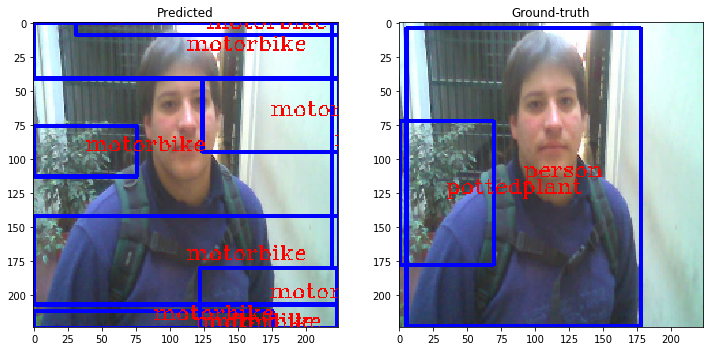

In [29]:
example = data_list[split_idx:][i]
img_str = IMG_PATH + img_file
f, axs = plt.subplots(1, 2, figsize=(12, 12))

img_pred = display.read_img(img_str, target_size)
img_pred = display.draw_boxes(img_pred, [bb.bounding_box for bb in output_bb])
img_pred = display.draw_text(img_pred, [bb.classname for bb in output_bb], [bb.bounding_box for bb in output_bb])
axs[0].imshow(img_pred)
axs[0].set_title("Predicted")

img_gt = display.read_img(img_str, target_size)
img_gt = display.draw_boxes(img_gt, example.bounding_boxes)
img_gt = display.draw_text(img_gt, example.classnames, example.bounding_boxes)
axs[1].imshow(img_gt)
axs[1].set_title("Ground-truth")

plt.show()